In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import cv2 as cv
from torchvision.transforms import ToTensor
from torch_snippets import Report
import numpy as np
import torch.utils.data
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)


c:\Users\heigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
piece_lookup = {
    0 : "K",
    1 : "Q",
    2 : "R",
    3 : "B",
    4 : "N",
    5 : "P",
    6 : "k",
    7 : "q",
    8 : "r",
    9 : "b",
    10 : "n",
    11 : "p",
    6 : "1",
}

value_lookup = {
    "K" : 0,
    "Q" : 1,
    "R" : 2,
    "B" : 3,
    "N" : 4,
    "P" : 5,
    "k" : 6,
    "q" : 7,
    "r" : 8,
    "b" : 9,
    "n" : 10,
    "p" : 11,
}

def y_to_fens(results):
    fens = []

    for i in range(results.shape[0]):
        fen = ''
        empty = 0

        for j in range(64):
            if np.argmax(results[i, j, :]) == 12:
                empty += 1
            else:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                piece_idx = np.argmax(results[i, j, :])
                fen += piece_lookup[piece_idx]

            if (j+1) % 8 == 0 and j < 63:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                fen += '/'

        fens.append(fen)
    
    return fens

def fens_to_y(fens):
    results = np.zeros((len(fens), 64, 13))

    for i, fen in enumerate(fens):

        fen = fen.split()[0]
        
        rows = fen.split('/')
        col = 0
        for j, row in enumerate(rows):  
            for char in row:
                if char.isdigit():
                    aux = col + int(char)
                    results[i, col:aux, 12] = 1
                    col = aux
                else:
                    piece_idx = value_lookup[char]
                    results[i, col, piece_idx] = 1
                    col += 1

    return results

In [3]:
class PieceImageClassifier(nn.Module):
    def __init__(self):
        super(PieceImageClassifier, self).__init__()

        self.model = models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT")

        self.model.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 12)
        )

    def forward(self, x):
        aux = self.model.features(x)
        outputs = self.model.classifier(aux)
        return outputs

class GamesDataset(Dataset):
    def __init__(self, images, fen):
        self.x = images
        self.y = torch.from_numpy(fen).type(torch.FloatTensor)
        self.n_samples = images.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.n_samples

In [4]:
imagens_array = torch.load("Dataset\Pecas\imagens_casa_tensor20000.pt")
fens = np.load("Dataset\Pecas\pecas_casa_tensor20000.npy")
for i in range(40000, 60001, 20000):
    imagens_array_load = torch.load(f"Dataset\Pecas\imagens_casa_tensor{i}.pt")
    fens_load = np.load(f"Dataset\Pecas\pecas_casa_tensor{i}.npy")

    imagens_array = torch.cat((imagens_array, imagens_array_load), dim=0)
    fens = np.concatenate((fens, fens_load), axis=0)


print(imagens_array.size())
print(fens.shape)

torch.Size([60000, 3, 224, 224])
(60000, 12)


In [5]:
class_frequencies = np.sum(fens[:int(len(fens)*.70)], axis=0)

class_frequencies = torch.from_numpy(class_frequencies).float()
weights = 1.0 / (class_frequencies + 1e-6)
weights = weights / weights.sum()

print("Class frequencies:", class_frequencies)
print("Class weights:", weights)

datasetTrain = GamesDataset(imagens_array[:int(len(imagens_array)*.70)], fens[:int(len(fens)*.70)])

sample_weights = np.zeros(len(datasetTrain))
for idx, (_, fen) in enumerate(datasetTrain):
    class_idx = fen.nonzero()[0].item()
    sample_weights[idx] = weights[class_idx]

sample_weights = torch.from_numpy(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=30000, replacement=True)

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=32, sampler=sampler)

datasetTest = GamesDataset(imagens_array[int(len(imagens_array)*.70):], fens[int(len(fens)*.70):])
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=32)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Test: {len(dataLoaderTest.dataset)}")

Class frequencies: tensor([10337.,  2319.,  2382.,  2965.,  1445.,  1546., 10264.,  2262.,  2549.,
         2953.,  1433.,  1545.])
Class weights: tensor([0.0185, 0.0823, 0.0801, 0.0644, 0.1321, 0.1235, 0.0186, 0.0844, 0.0749,
        0.0646, 0.1332, 0.1235])
Train: 42000
Test: 18000


In [6]:
model = PieceImageClassifier()
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [7]:
num_epochs = 20
log = Report(num_epochs)


for epoch in range(num_epochs):

    model.train()        
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):
        total = 0
        right = 0

        pos, fen_y = data

        pos = pos.to(device)
        fen_y = fen_y.to(device)

        fen_pred = model(pos)

        loss = criterion(fen_pred, fen_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        fen_pred = fen_pred.cpu().detach().numpy().astype('float32')
        fen_y = fen_y.cpu().detach().numpy().astype('float32')

        for i in range(len(fen_pred)):
            total += 1            
            if np.argmax(fen_pred[i, :]) == np.argmax(fen_y[i, :]):
                right += 1

    
        accuracy_train = right/total * 100

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=accuracy_train, end='\r')



    model.eval()
    with torch.no_grad():                
        N = len(dataLoaderTest)
        for bx, data in enumerate(dataLoaderTest):
            total = 0
            right = 0

            pos, fen_y = data

            pos = pos.to(device)
            fen_y = fen_y.to(device)

            fen_pred = model(pos)

            loss_test = criterion(fen_pred, fen_y)

            fen_pred = fen_pred.cpu().detach().numpy().astype('float32')
            fen_y = fen_y.cpu().detach().numpy().astype('float32')

            for i in range(len(fen_pred)):
                total += 1                
                if np.argmax(fen_pred[i, :]) == np.argmax(fen_y[i, :]):
                    right += 1

            accuracy_test = right/total * 100


            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=accuracy_test, end='\r')
    
    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()


torch.save(model.state_dict(), 'Mestrado/Models/imageClassifier.pth')


EPOCH: 2.000  val_loss: 1.492  val_acc: 81.750  trn_acc: 86.261  trn_loss: 1.863  (223.02s - 2007.14s remaining)
EPOCH: 4.000  val_loss: 0.926  val_acc: 84.675  trn_acc: 89.772  trn_loss: 1.017  (436.06s - 1744.25s remaining)
EPOCH: 6.000  val_loss: 0.606  val_acc: 87.328  trn_acc: 90.525  trn_loss: 0.652  (646.24s - 1507.89s remaining)
EPOCH: 8.000  val_loss: 0.472  val_acc: 88.643  trn_acc: 91.071  trn_loss: 0.495  (856.06s - 1284.09s remaining)
EPOCH: 10.000  val_loss: 0.416  val_acc: 90.037  trn_acc: 91.858  trn_loss: 0.415  (1067.60s - 1067.60s remaining)
EPOCH: 12.000  val_loss: 0.308  val_acc: 89.404  trn_acc: 92.331  trn_loss: 0.370  (1277.83s - 851.88s remaining)
EPOCH: 14.000  val_loss: 0.377  val_acc: 90.420  trn_acc: 92.214  trn_loss: 0.352  (1493.68s - 640.15s remaining)
EPOCH: 16.000  val_loss: 0.328  val_acc: 90.292  trn_acc: 92.704  trn_loss: 0.332  (1695.29s - 423.82s remaining)
EPOCH: 18.000  val_loss: 0.336  val_acc: 89.565  trn_acc: 92.627  trn_loss: 0.326  (1897.47

100%|██████████| 121/121 [00:00<00:00, 206.65it/s]


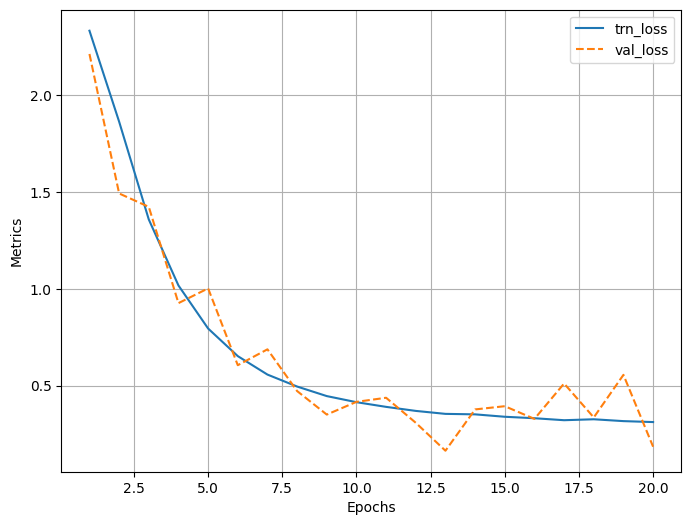

100%|██████████| 121/121 [00:00<00:00, 212.46it/s]


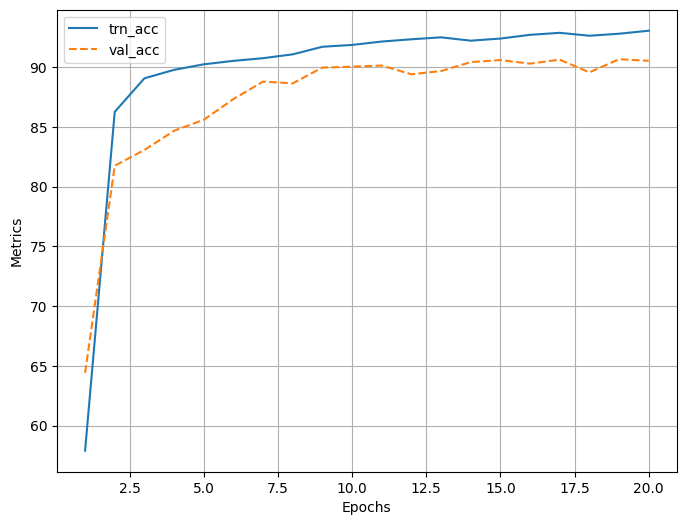

In [8]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

# Teste e matriz de confusão

In [9]:
imagens_array = torch.load("Dataset\Pecas\imagens_casa_tensor80000.pt")
fens = np.load("Dataset\Pecas\pecas_casa_tensor80000.npy")
# for i in range(20000, 30001, 10000):
#     imagens_array_load = torch.load(f"Dataset\Pecas\imagens_casa_tensor{i}.pt")
#     fens_load = np.load(f"Dataset\Pecas\pecas_casa_tensor{i}.npy")

#     imagens_array = torch.cat((imagens_array, imagens_array_load), dim=0)
#     fens = np.concatenate((fens, fens_load), axis=0)


print(imagens_array.size())
print(fens.shape)

torch.Size([20000, 3, 224, 224])
(20000, 12)


In [10]:
datasetTest = GamesDataset(imagens_array, fens)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=64)

print(f"Test: {len(dataLoaderTest.dataset)}")

Test: 20000


In [11]:
model = PieceImageClassifier()
model.to(device)
model.load_state_dict(torch.load("Mestrado\Models\imageClassifier.pth"))
model.eval()

PieceImageClassifier(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

Test Accuracy: 90.50%


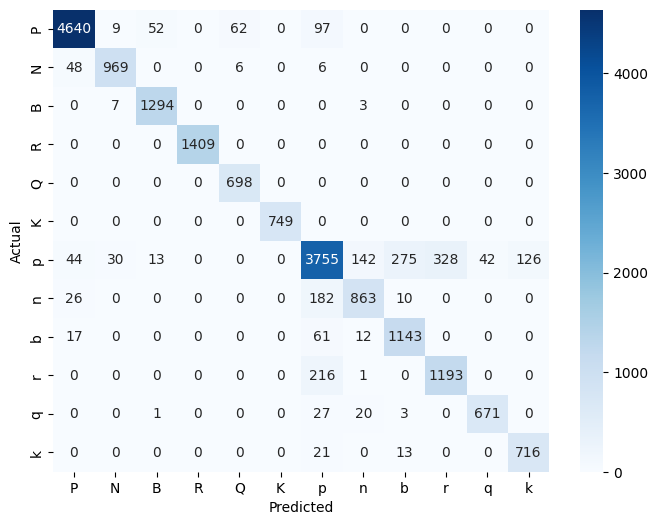

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a mapping between numeric labels and letters
label_mapping = {0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K', 6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'}

total = 0
right = 0
y_true = []
y_pred = []

with torch.no_grad():                
    N = len(dataLoaderTest)
    for bx, data in enumerate(dataLoaderTest):

        pos, fen_y = data

        pos = pos.to(device)
        fen_y = fen_y.to(device)

        fen_pred = model(pos)

        fen_pred = fen_pred.cpu().detach().numpy().argmax(axis=1)
        fen_y = fen_y.cpu().detach().numpy().argmax(axis=1)

        y_true.extend(fen_y)
        y_pred.extend(fen_pred)

        total += len(fen_y)                
        right += np.sum(fen_pred == fen_y)

accuracy_test = right/total * 100

print(f"Test Accuracy: {accuracy_test:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert numeric labels to letters
label_names = [label_mapping[i] for i in range(len(label_mapping))]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
